## Detailed Description

### Introduction

Paris is the capital of France and the most populous city in the country. Being the City of Light it is the world's most visited capital. The city is proud of its many monuments from the iconic Eiffel Tower to the lofty Notre-Dame cathedral and the majestic Arc de Triomphe. No doubt this is Europe's most enchanting capital. Paris is divided into [20 arrondissements](https://en.wikipedia.org/wiki/Arrondissements_of_Paris) and 80 neighborhoods (4 neighborhoods in each arrondissement). Each Neighborhood may have different popular venues, and thus if we can find similar neighbors and their popular venue categories, it may help Businesses in making Investment Decisions.

The target audience for this project are Businesses/Organizations and Entrepreneurs who wants to make smart and data-driven investment decisions in Paris that are profitable for their business ventures.

### Problem Statement

The main aim of this project is to find the most popular and common venues in each neighborhood of Paris and cluster them based on similar categories of venues. It can aid potential investors in identifying the best choice of neighborhood for their business. For example, someone looking to open a french restaurant in paris can identify the neighborhoods where the competition is less and supermarkets are easily accessible for food supplies. 

### Data

First, we have to find out all the neighborhoods of Paris city. We will download the relevant data from trusted sources like the french government website and other open data sources provided by local authorities of Paris city. Further, we would need location data (postal codes, coordinates) of each of these neighborhoods, which we will obtain using the Geopy Library. Lastly, to find the nearby venues of each neighborhood using their location coordinates we will utilize the Foursquare API. 

### Required Libraries

- pandas 
- numpy
- json
- geopy
- scikit-learn
- folium
- matplotlib
- yellowbrick
- requests
- itertools

### Importing the required libraries

In [1]:
import pandas as pd  # for data visualization

from itertools import repeat # for using extend() + itertools.repeat() 

import json  # to handle json files 

#!conda install -c conda-forge geopy --yes  # uncomment this line if you do not have geopy module installed
from geopy.geocoders import Nominatim  # for obtaining geographical data 

import folium # for plotting on maps

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # to handle requests

import numpy as np # for faster computing on vetors

# import k-means from clustering stage
from sklearn.cluster import KMeans


#!conda install -c districtdatalabs yellowbrick --yes #uncomment this line if you do not have yellowbrick installed
#!conda install -c conda-forge scikit-learn==0.20.0 --yes # i got an error with using yellow brick package with other version of
                                                          # scikit-learn to i installed specific version 0.20.0

# yellowbrick is a high-level API built on top of scikit-learn
from yellowbrick.cluster import KElbowVisualizer

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

### Download the paris arrondissements(Borough) dataset from the official french goverment website and nieghborhood dataset from official opendata website.

In [2]:
!wget -q -O "borough_data.json" https://www.data.gouv.fr/en/datasets/r/871c68bf-c92b-42a9-8dcc-910f9be0b870
!wget -q -O "neighborhood_data.json" "https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=json&timezone=Europe/Berlin"

### Load the JSON file containing Borough and Neighborhood data using json.load() function.

In [3]:
with open('borough_data.json') as json_data:
    borough_data = json.load(json_data)

In [4]:
with open('neighborhood_data.json') as json_data:
    neighborhood_data = json.load(json_data)

### See the contents of the JSON file. 

In [5]:
#borough_data

In [6]:
#neighborhood_data

### Initialize an empty dataframe with the required columns. Check if it is correctly created.

In [7]:
column_names = ['Borough_No','Borough','Latitude', 'Longitude'] 
# instantiate the dataframe
borough_df = pd.DataFrame(columns=column_names)
borough_df

,Borough_No,Borough,Latitude,Longitude


### Extract the data from the JSON file and insert it into the data frame which we initialized earlier.

In [8]:
# Extract the data recursively from the JSON file.
for data in borough_data:
    borough_no = data['fields']['c_ar']  # extract the arrondissements/district number.
    borough_name = data['fields']['l_aroff'] # extract the name of arrondissements/district.
        
    lat_lon = data['fields']['geom_x_y']  # extract the latitude and longitudes for each Arrondissements.
    lat = lat_lon[0]  # extract latitude from combined coordinates.
    long = lat_lon[1] # extract longitude from combined coordinates.

    # append the data into the dataframe
    borough_df = borough_df.append({'Borough_No':borough_no,
                                          'Borough':borough_name,
                                          'Latitude': lat,
                                          'Longitude': long}, ignore_index=True)

### Now check the dataframe filled with the data which was just extracted.

In [9]:
borough_df

,Borough_No,Borough,Latitude,Longitude
0,5,Panthéon,48.844443,2.350715
1,8,Élysée,48.872721,2.312554
2,13,Gobelins,48.828388,2.362272
3,4,Hôtel-de-Ville,48.854341,2.357630
4,14,Observatoire,48.829245,2.326542
5,12,Reuilly,48.834974,2.421325
6,6,Luxembourg,48.849130,2.332898
7,3,Temple,48.862872,2.360001
8,7,Palais-Bourbon,48.856174,2.312188
9,11,Popincourt,48.859059,2.380058


### As you can see there are 20 Borough in paris each assigned numbers from 1 to 20.

### Sorting the values in dataframe by Borough number in ascending order

In [10]:
borough_df.sort_values(by='Borough_No',inplace=True)

### Reset the index after sorting to avoid any issue later.

In [11]:
borough_df.reset_index(drop=True,inplace=True)

### Check out the sorted data frame.

In [12]:
borough_df

,Borough_No,Borough,Latitude,Longitude
0,1,Louvre,48.862563,2.336443
1,2,Bourse,48.868279,2.342803
2,3,Temple,48.862872,2.360001
3,4,Hôtel-de-Ville,48.854341,2.357630
4,5,Panthéon,48.844443,2.350715
5,6,Luxembourg,48.849130,2.332898
6,7,Palais-Bourbon,48.856174,2.312188
7,8,Élysée,48.872721,2.312554
8,9,Opéra,48.877164,2.337458
9,10,Entrepôt,48.876130,2.360728


### Defining a common function which will be use to extract the postal codes using geopy library.

In [13]:
def get_postcode(latitude,longitude,user_agent):
    geolocator = Nominatim(user_agent=user_agent)
    location = geolocator.reverse("{},{}".format(latitude,longitude))
    postcode = location.raw['address']['postcode']
    return postcode

### Parsing the values to the function i.e. latitude and longitude coordinates from the dataframe along with the user-agent value to extract postal codes for all the districts into a list.

In [14]:
user_agent = "paris_explorer"
list_post_codes = []
for i in borough_df[['Latitude','Longitude']].values:
    postcodes = get_postcode(i[0],i[1],user_agent)
    list_post_codes.append(postcodes)
list_post_codes

['75001',
 '75002',
 '75003',
 '75004',
 '75005',
 '75006',
 '75007',
 '75008',
 '75009',
 '75010',
 '75011',
 '75012',
 '75013',
 '75014',
 '75015',
 '75016',
 '75017',
 '75018',
 '75019',
 '75020']

### Appending the list of postal codes obtained to our dataframe as the first column.

In [15]:
# Using DataFrame.insert() to add a column 
borough_df.insert(0, "Postal Code", list_post_codes, True)

### Passing some additional parameters to print out dataframe in a neat and clean way.

In [16]:
borough_df.style.set_properties(**{'text-align': 'center'}).hide_index()

Postal Code,Borough_No,Borough,Latitude,Longitude
75001,1,Louvre,48.862563,2.336443
75002,2,Bourse,48.868279,2.342803
75003,3,Temple,48.862872,2.360001
75004,4,Hôtel-de-Ville,48.854341,2.357630
75005,5,Panthéon,48.844443,2.350715
75006,6,Luxembourg,48.849130,2.332898
75007,7,Palais-Bourbon,48.856174,2.312188
75008,8,Élysée,48.872721,2.312554
75009,9,Opéra,48.877164,2.337458
75010,10,Entrepôt,48.876130,2.360728


### Creating a data frame for neighborhoods from Neighborhood JSON file.

In [17]:
column_names = ['Borough_No','Neighborhood','Latitude', 'Longitude'] 
# instantiate the dataframe
neighborhood_df = pd.DataFrame(columns=column_names)
neighborhood_df

,Borough_No,Neighborhood,Latitude,Longitude


In [18]:
# Extract the data recursively from the JSON file.
for data in neighborhood_data:
    borough_no = data['fields']['c_ar']  # extract the arrondissements/district number.
    neighborhood_name = data['fields']['l_qu'] # extract the name of arrondissements/district.
        
    lat_lon = data['fields']['geom_x_y']  # extract the latitude and longitudes for each Arrondissements.
    lat = lat_lon[0]  # extract latitude from combined coordinates.
    long = lat_lon[1] # extract longitude from combined coordinates.

    # append the data into the dataframe
    neighborhood_df = neighborhood_df.append({'Borough_No':borough_no,
                                          'Neighborhood':neighborhood_name,
                                          'Latitude': lat,
                                          'Longitude': long}, ignore_index=True)

In [19]:
neighborhood_df.sort_values(by='Borough_No',inplace=True)

In [20]:
neighborhood_df.reset_index(drop=True,inplace=True)

In [21]:
neighborhood_df

,Borough_No,Neighborhood,Latitude,Longitude
0,1,Halles,48.862289,2.344899
1,1,Place-Vendôme,48.867019,2.328582
2,1,Saint-Germain-l'Auxerrois,48.860650,2.334910
3,1,Palais-Royal,48.864660,2.336309
4,2,Gaillon,48.869307,2.333432
...,...,...,...,...
75,19,Amérique,48.881638,2.395440
76,20,Charonne,48.854760,2.407430
77,20,Saint-Fargeau,48.871035,2.406172
78,20,Belleville,48.871531,2.387549


### Now we will merge both the data frames with only the data that we require for use further.

### To use the insert function to insert a column in data frame, the number of index should match but we only have 20 borough and 80 neighbourhoods as each borough contains four neighborhood so we will have to create a list of borough by duplicating each borough name 3 more times that is total 4 times each to make it a list of size 80.

In [22]:
list_borough_names = []
for data in list(borough_df['Borough']):
    list_borough_names.extend(repeat(data,4))

In [23]:
merged_df =neighborhood_df
merged_df.insert(1,"Borough",list_borough_names,True)

In [24]:
merged_df.head(10)

,Borough_No,Borough,Neighborhood,Latitude,Longitude
0,1,Louvre,Halles,48.862289,2.344899
1,1,Louvre,Place-Vendôme,48.867019,2.328582
2,1,Louvre,Saint-Germain-l'Auxerrois,48.860650,2.334910
3,1,Louvre,Palais-Royal,48.864660,2.336309
4,2,Bourse,Gaillon,48.869307,2.333432
5,2,Bourse,Bonne-Nouvelle,48.867150,2.350080
6,2,Bourse,Mail,48.868008,2.344699
7,2,Bourse,Vivienne,48.869100,2.339461
8,3,Temple,Archives,48.859192,2.363205
9,3,Temple,Arts-et-Métiers,48.866470,2.357083


### Use geopy library to get the latitude and longitude values of Paris City to plot the data on the map of .

In [25]:
address = 'Paris, France'

geolocator = Nominatim(user_agent=user_agent)
location = geolocator.geocode(address)
paris_latitude = location.latitude
paris_longitude = location.longitude
print('The geograpical coordinate of Paris City are {}, {}.'.format(paris_latitude, paris_longitude))

The geograpical coordinate of Paris City are 48.8566969, 2.3514616.


### Plotting all the Boroughs on the map with their names and number using folium.

In [26]:
# create map of Paris city using latitude and longitude values.
paris_map = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=10)

# add markers to map
for lat, lng, Neighborhood_Name, Borough_Name, Borough_No in zip(merged_df['Latitude'], 
                                                                               merged_df['Longitude'], 
                                                                               merged_df['Neighborhood'],
                                                                               merged_df['Borough'], 
                                                                               merged_df['Borough_No']):
    
    label = '{}, {}, {}'.format(Neighborhood_Name, Borough_Name, Borough_No)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(paris_map)  
    
paris_map

### Define Foursquare Credentials and Version

In [27]:
CLIENT_ID = 'define your client ID here' # your Foursquare ID
CLIENT_SECRET = 'define your client secret here' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [28]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [29]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
def get_venues_nearby(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
paris_venues = get_venues_nearby(names=merged_df['Neighborhood'],
                                   latitudes=merged_df['Latitude'],
                                   longitudes=merged_df['Longitude']
                                  )

Halles
Place-Vendôme
Saint-Germain-l'Auxerrois
Palais-Royal
Gaillon
Bonne-Nouvelle
Mail
Vivienne
Archives
Arts-et-Métiers
Enfants-Rouges
Sainte-Avoie
Arsenal
Saint-Gervais
Saint-Merri
Notre-Dame
Sorbonne
Saint-Victor
Val-de-Grâce
Jardin-des-Plantes
Notre-Dame-des-Champs
Odéon
Monnaie
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Ecole-Militaire
Invalides
Gros-Caillou
Faubourg-du-Roule
Madeleine
Europe
Champs-Elysées
Faubourg-Montmartre
Saint-Georges
Chaussée-d'Antin
Rochechouart
Porte-Saint-Martin
Hôpital-Saint-Louis
Porte-Saint-Denis
Saint-Vincent-de-Paul
Folie-Méricourt
Roquette
Sainte-Marguerite
Saint-Ambroise
Bercy
Picpus
Quinze-Vingts
Bel-Air
Croulebarbe
Maison-Blanche
Salpêtrière
Gare
Plaisance
Parc-de-Montsouris
Petit-Montrouge
Montparnasse
Saint-Lambert
Javel
Grenelle
Necker
Muette
Auteuil
Chaillot
Porte-Dauphine
Batignolles
Epinettes
Ternes
Plaine de Monceaux
Grandes-Carrières
La Chapelle
Clignancourt
Goutte-d'Or
Pont-de-Flandre
Combat
Villette
Amérique
Charonne
Saint-Fargeau
Be

In [33]:
print(paris_venues.shape)

(5087, 7)


In [34]:
paris_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Halles,48.862289,2.344899,LEGO® Store,48.861818,2.347191,Toy / Game Store
1,Halles,48.862289,2.344899,Café Belleville,48.861378,2.346756,Café
2,Halles,48.862289,2.344899,Spa Nuxe,48.864017,2.346650,Spa
3,Halles,48.862289,2.344899,Hôtel Maison Albar Paris Céline,48.860552,2.344259,Hotel
4,Halles,48.862289,2.344899,Boulangerie Julien,48.861251,2.344170,Bakery
5,Halles,48.862289,2.344899,Pirouette,48.862876,2.348135,French Restaurant
6,Halles,48.862289,2.344899,La Régalade Saint-Honoré,48.861620,2.341749,French Restaurant
7,Halles,48.862289,2.344899,Hapimag Resort Paris,48.861392,2.342621,Hotel
8,Halles,48.862289,2.344899,Christian Louboutin,48.862697,2.340757,Shoe Store
9,Halles,48.862289,2.344899,Fromagerie Danard,48.863297,2.340948,Cheese Shop


In [35]:
paris_venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Amérique,13,13,13,13,13,13
Archives,100,100,100,100,100,100
Arsenal,67,67,67,67,67,67
Arts-et-Métiers,100,100,100,100,100,100
Auteuil,16,16,16,16,16,16
Batignolles,100,100,100,100,100,100
Bel-Air,6,6,6,6,6,6
Belleville,40,40,40,40,40,40
Bercy,75,75,75,75,75,75


In [36]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 297 uniques categories.


In [39]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

#paris_onehot['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Halles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Halles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Halles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Halles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Halles,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
paris_onehot.shape

(5087, 298)

In [41]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Amérique,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,Archives,0.0,0.0,0.01,0.000000,0.000000,0.0,0.00,0.04,0.0,...,0.0,0.0,0.000000,0.0,0.020000,0.000000,0.0,0.0,0.0,0.0
2,Arsenal,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.014925,0.000000,0.0,0.0,0.0,0.0
3,Arts-et-Métiers,0.0,0.0,0.00,0.000000,0.000000,0.0,0.01,0.02,0.0,...,0.0,0.0,0.030000,0.0,0.050000,0.020000,0.0,0.0,0.0,0.0
4,Auteuil,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Sorbonne,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,...,0.0,0.0,0.010000,0.0,0.020000,0.010000,0.0,0.0,0.0,0.0
76,Ternes,0.0,0.0,0.00,0.014706,0.000000,0.0,0.00,0.00,0.0,...,0.0,0.0,0.014706,0.0,0.014706,0.000000,0.0,0.0,0.0,0.0
77,Val-de-Grâce,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.021739,0.000000,0.0,0.0,0.0,0.0
78,Villette,0.0,0.0,0.00,0.017544,0.000000,0.0,0.00,0.00,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [42]:
paris_grouped.shape

(80, 298)

### Finding the top 5 venues in all the neighborhoods

In [43]:
num_top_venues = 5

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
               venue  freq
0        Supermarket  0.15
1  French Restaurant  0.15
2               Café  0.15
3               Pool  0.15
4              Plaza  0.15


----Archives----
                venue  freq
0   French Restaurant  0.09
1               Hotel  0.07
2         Coffee Shop  0.05
3                 Bar  0.04
4  Italian Restaurant  0.04


----Arsenal----
                venue  freq
0   French Restaurant  0.18
1               Hotel  0.07
2  Seafood Restaurant  0.04
3               Plaza  0.04
4                Park  0.04


----Arts-et-Métiers----
               venue  freq
0  French Restaurant  0.09
1              Hotel  0.06
2       Cocktail Bar  0.06
3           Wine Bar  0.05
4         Restaurant  0.04


----Auteuil----
                   venue  freq
0           Tennis Court  0.31
1                 Garden  0.12
2                Stadium  0.12
3  Outdoors & Recreation  0.06
4    Sporting Goods Shop  0.06


----Batignolles----
                venue  freq
0   Fr

### Defining a function to return the most common venues

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### finding the 10 top/most common venues for all neighborhood and creating a dataframe of it.

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

In [46]:
neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,French Restaurant,Supermarket,Pool,Café,Plaza,Bed & Breakfast,Bistro,Park,Deli / Bodega,Department Store
1,Archives,French Restaurant,Hotel,Coffee Shop,Art Gallery,Italian Restaurant,Bar,Burger Joint,Bistro,Tapas Restaurant,Japanese Restaurant
2,Arsenal,French Restaurant,Hotel,Plaza,Seafood Restaurant,Park,Tapas Restaurant,Pedestrian Plaza,Cocktail Bar,Gastropub,Vegetarian / Vegan Restaurant
3,Arts-et-Métiers,French Restaurant,Cocktail Bar,Hotel,Wine Bar,Italian Restaurant,Restaurant,Moroccan Restaurant,Bar,Japanese Restaurant,Chinese Restaurant
4,Auteuil,Tennis Court,Garden,Stadium,Racecourse,Botanical Garden,Office,Outdoors & Recreation,Museum,French Restaurant,Sporting Goods Shop
5,Batignolles,French Restaurant,Hotel,Italian Restaurant,Bar,Bistro,Restaurant,Japanese Restaurant,Café,Park,Chinese Restaurant
6,Bel-Air,Sports Club,French Restaurant,Recreation Center,Plaza,Playground,Café,Fast Food Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit
7,Belleville,Bar,French Restaurant,Burger Joint,Restaurant,Japanese Restaurant,Beer Store,Theater,Thai Restaurant,Cocktail Bar,Chinese Restaurant
8,Bercy,Hotel,Bakery,French Restaurant,Breakfast Spot,Museum,Japanese Restaurant,Italian Restaurant,Bar,Plaza,Bike Rental / Bike Share
9,Bonne-Nouvelle,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Italian Restaurant,Hotel,Japanese Restaurant,Coffee Shop,Restaurant,Bar


### Drop categorical columns from the paris_grouped data frame to make data ready to be fed into K-Means algorithm.

In [47]:
paris_grouped_clustering = paris_grouped.drop('Neighborhood',1)
paris_grouped_clustering

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.01,0.000000,0.000000,0.0,0.00,0.04,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.020000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.014925,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.000000,0.000000,0.0,0.01,0.02,0.0,0.00,...,0.0,0.0,0.030000,0.0,0.050000,0.020000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,0.01,...,0.0,0.0,0.010000,0.0,0.020000,0.010000,0.0,0.0,0.0,0.0
76,0.0,0.0,0.00,0.014706,0.000000,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.014706,0.0,0.014706,0.000000,0.0,0.0,0.0,0.0
77,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.021739,0.000000,0.0,0.0,0.0,0.0
78,0.0,0.0,0.00,0.017544,0.000000,0.0,0.00,0.00,0.0,0.00,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


### Running K Means algorithm with multiple values of K and then evaluating it using elbow method and plotting the graph to determine the optimal K.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


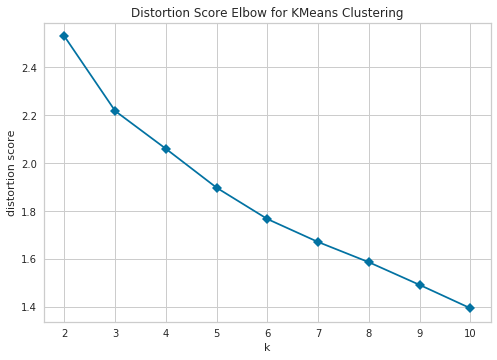

In [48]:
# using yellow brick to find the best K using elbow method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11), metric='distortion', timings=False, locate_elbow=False)

visualizer.fit(paris_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### As we can see the sharpest decline is from k=2 to k=3. so we will choose the values of clusters = 3 for clustering.

In [49]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(paris_grouped_clustering)

### Check out lables predicted

In [50]:
kmeans.labels_[0:80]

array([1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1,
       2, 1, 1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1], dtype=int32)

### Add the cluster lables as the first column to the original neighborhood venues data frame.

In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [52]:
neighborhoods_venues_sorted.head(10)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Amérique,French Restaurant,Supermarket,Pool,Café,Plaza,Bed & Breakfast,Bistro,Park,Deli / Bodega,Department Store
1,1,Archives,French Restaurant,Hotel,Coffee Shop,Art Gallery,Italian Restaurant,Bar,Burger Joint,Bistro,Tapas Restaurant,Japanese Restaurant
2,2,Arsenal,French Restaurant,Hotel,Plaza,Seafood Restaurant,Park,Tapas Restaurant,Pedestrian Plaza,Cocktail Bar,Gastropub,Vegetarian / Vegan Restaurant
3,1,Arts-et-Métiers,French Restaurant,Cocktail Bar,Hotel,Wine Bar,Italian Restaurant,Restaurant,Moroccan Restaurant,Bar,Japanese Restaurant,Chinese Restaurant
4,1,Auteuil,Tennis Court,Garden,Stadium,Racecourse,Botanical Garden,Office,Outdoors & Recreation,Museum,French Restaurant,Sporting Goods Shop
5,2,Batignolles,French Restaurant,Hotel,Italian Restaurant,Bar,Bistro,Restaurant,Japanese Restaurant,Café,Park,Chinese Restaurant
6,1,Bel-Air,Sports Club,French Restaurant,Recreation Center,Plaza,Playground,Café,Fast Food Restaurant,English Restaurant,Ethiopian Restaurant,Exhibit
7,1,Belleville,Bar,French Restaurant,Burger Joint,Restaurant,Japanese Restaurant,Beer Store,Theater,Thai Restaurant,Cocktail Bar,Chinese Restaurant
8,1,Bercy,Hotel,Bakery,French Restaurant,Breakfast Spot,Museum,Japanese Restaurant,Italian Restaurant,Bar,Plaza,Bike Rental / Bike Share
9,1,Bonne-Nouvelle,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Italian Restaurant,Hotel,Japanese Restaurant,Coffee Shop,Restaurant,Bar


### Combine neighborhood venues data frame and the merged data frame of Borough and neighborhood.

In [53]:
paris_merged = merged_df[['Borough', 'Neighborhood', 'Latitude', 'Longitude']]

# merge paris_grouped with paris_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

### check out the newly created data frame.

In [54]:
paris_merged.head(10) # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Louvre,Halles,48.862289,2.344899,2,French Restaurant,Bakery,Hotel,Ice Cream Shop,Art Gallery,Cocktail Bar,Pedestrian Plaza,Cheese Shop,Coffee Shop,Plaza
1,Louvre,Place-Vendôme,48.867019,2.328582,2,French Restaurant,Hotel,Jewelry Store,Chocolate Shop,Japanese Restaurant,Boutique,Dessert Shop,Bookstore,Hotel Bar,Italian Restaurant
2,Louvre,Saint-Germain-l'Auxerrois,48.860650,2.334910,2,French Restaurant,Hotel,Plaza,Art Museum,Historic Site,Coffee Shop,Italian Restaurant,Cosmetics Shop,Exhibit,Clothing Store
3,Louvre,Palais-Royal,48.864660,2.336309,1,Japanese Restaurant,French Restaurant,Hotel,Italian Restaurant,Plaza,Historic Site,Wine Bar,Bookstore,Pastry Shop,Coffee Shop
4,Bourse,Gaillon,48.869307,2.333432,1,Japanese Restaurant,Hotel,French Restaurant,Chocolate Shop,Wine Bar,Italian Restaurant,Korean Restaurant,Theater,Jewelry Store,Food & Drink Shop
5,Bourse,Bonne-Nouvelle,48.867150,2.350080,1,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Italian Restaurant,Hotel,Japanese Restaurant,Coffee Shop,Restaurant,Bar
6,Bourse,Mail,48.868008,2.344699,1,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Hotel,Bar,Creperie,Coffee Shop,Boutique,Bistro
7,Bourse,Vivienne,48.869100,2.339461,1,French Restaurant,Japanese Restaurant,Hotel,Wine Bar,Coffee Shop,Bistro,Bookstore,Bakery,Salad Place,Clothing Store
8,Temple,Archives,48.859192,2.363205,1,French Restaurant,Hotel,Coffee Shop,Art Gallery,Italian Restaurant,Bar,Burger Joint,Bistro,Tapas Restaurant,Japanese Restaurant
9,Temple,Arts-et-Métiers,48.866470,2.357083,1,French Restaurant,Cocktail Bar,Hotel,Wine Bar,Italian Restaurant,Restaurant,Moroccan Restaurant,Bar,Japanese Restaurant,Chinese Restaurant


### plot the clusters formed on the map of paris.

In [55]:
# create map
map_clusters = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], 
                                  paris_merged['Longitude'], 
                                  paris_merged['Neighborhood'], 
                                  paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examining the cluster formed by K-Means. Also plotting the bar graphs of the venue type in each cluster v/s it's count and saving the high resolution images.

### Cluster-1

In [62]:
cluster_1 = paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
cluster_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Picpus,Locksmith,Hotel,Zoo Exhibit,Fish & Chips Shop,English Restaurant,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant


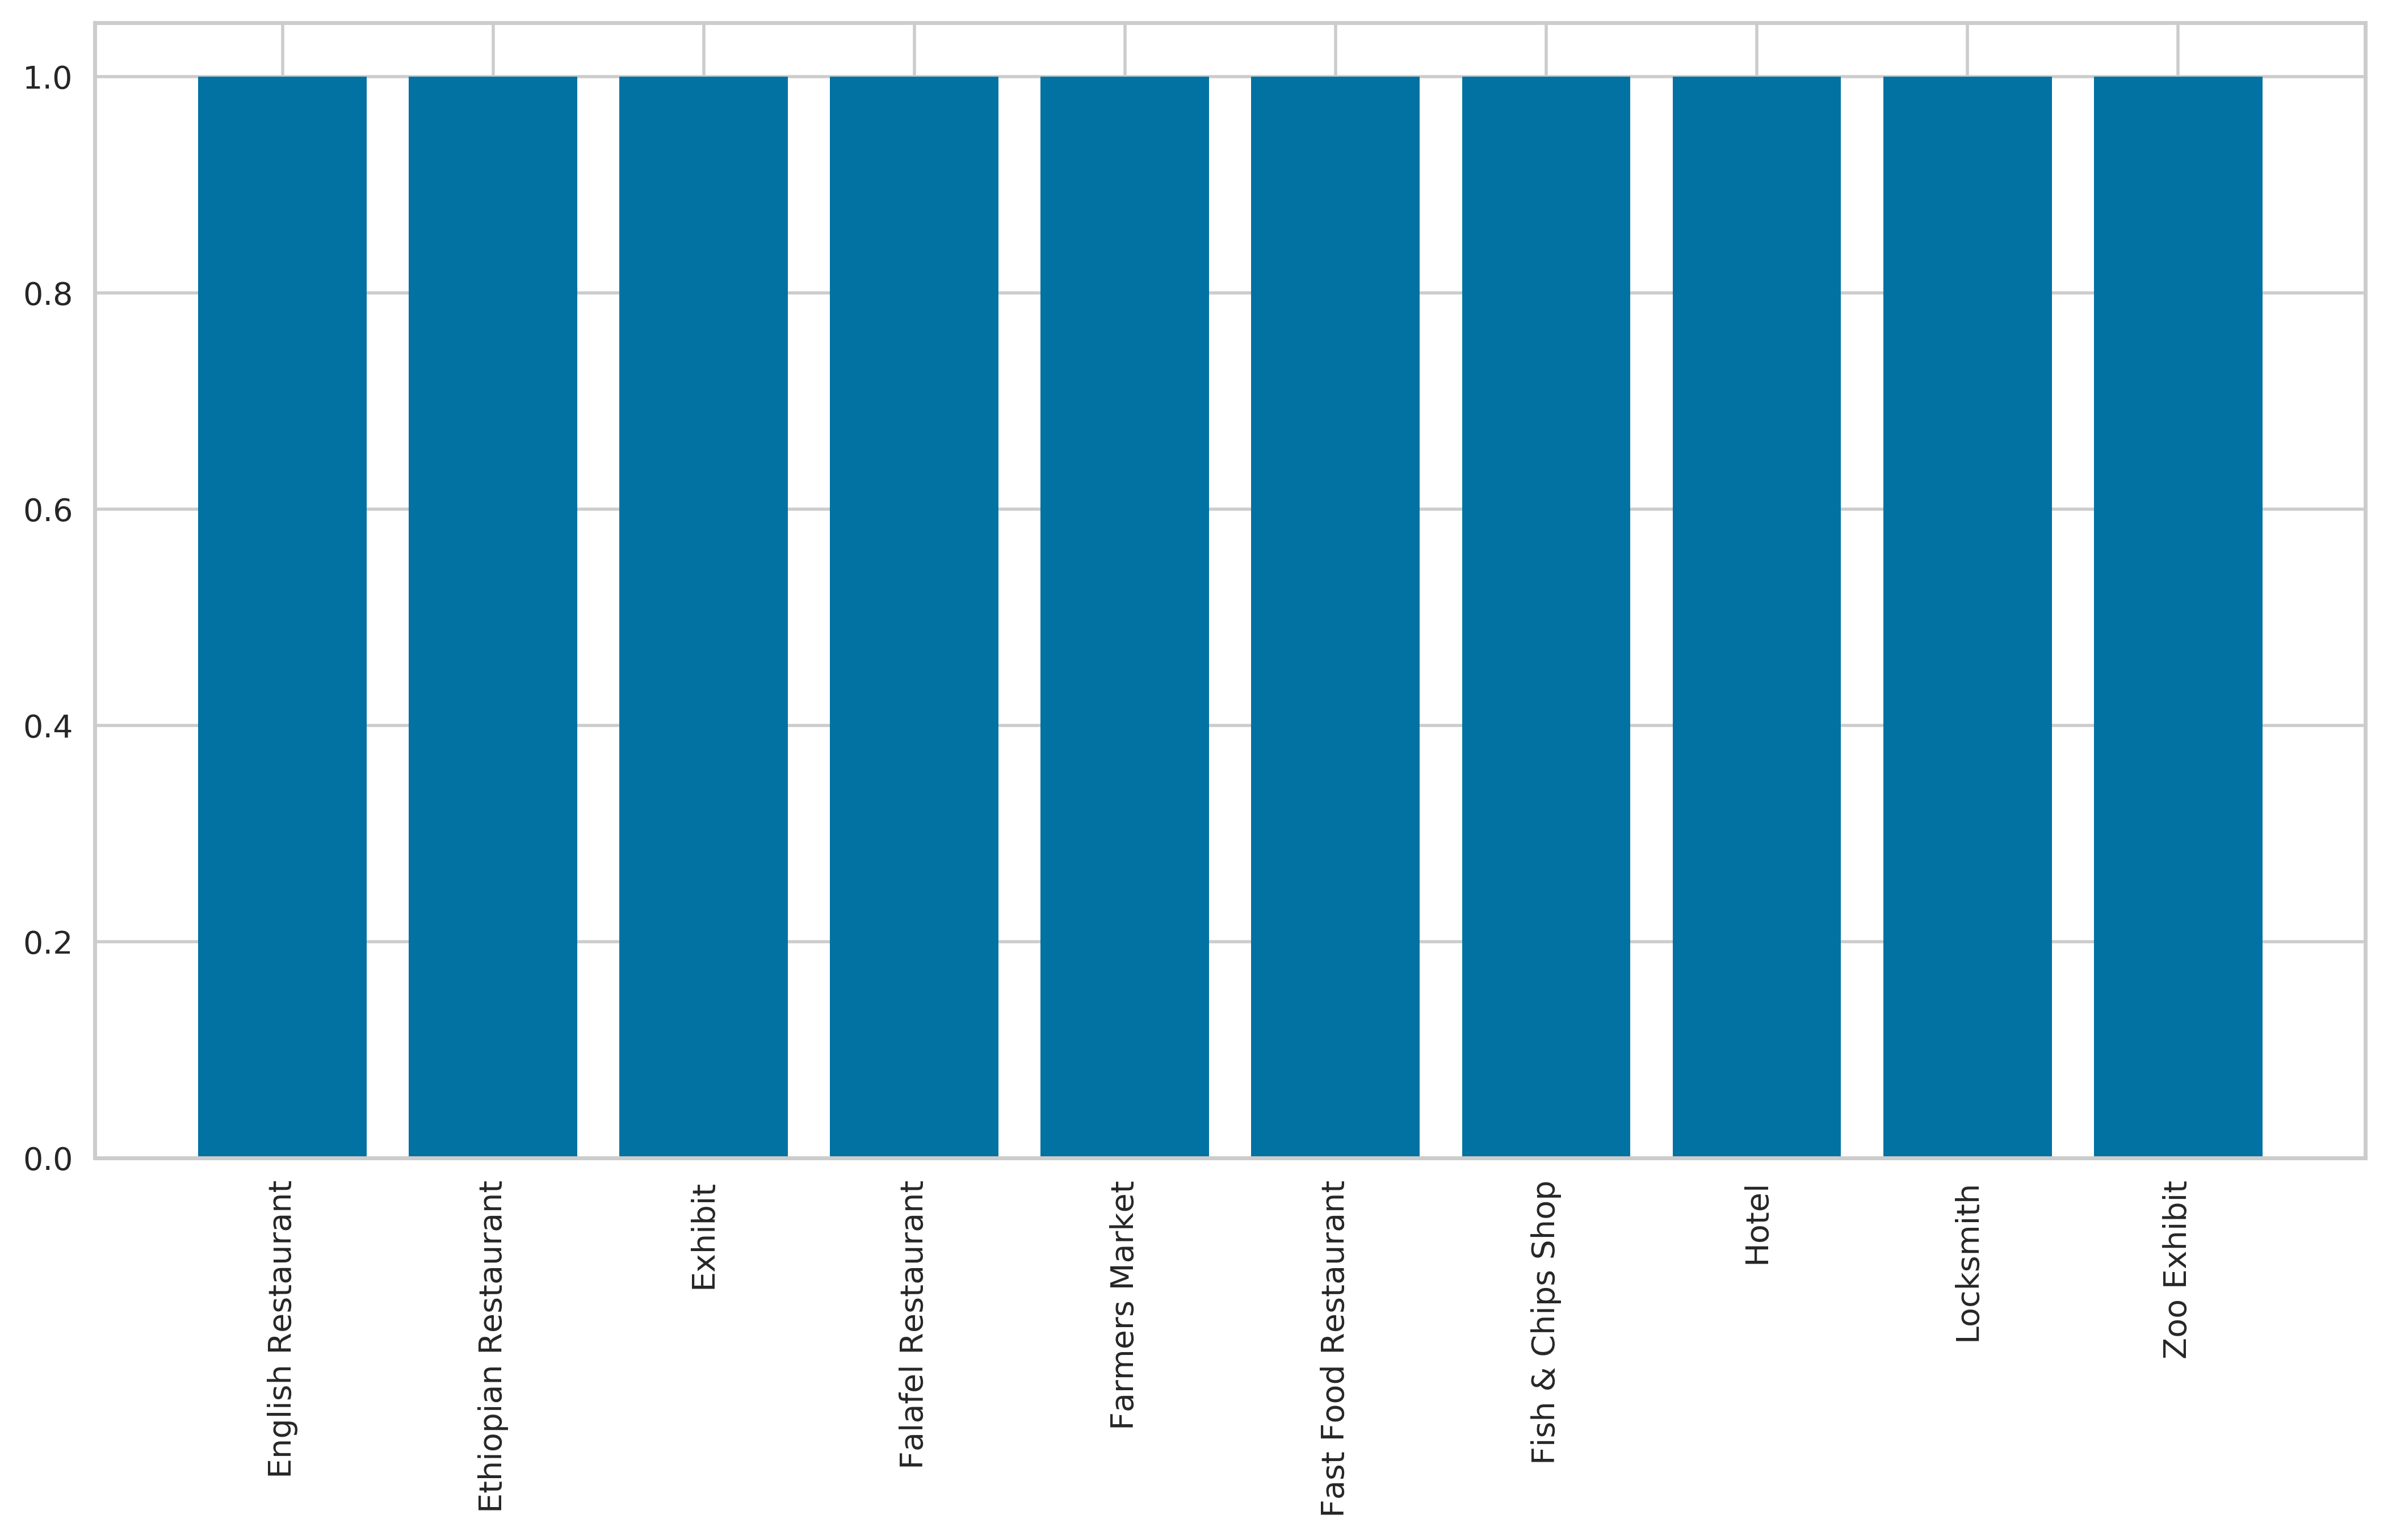

In [63]:
temp_series = pd.Series(dtype='object') 
temp_cluster = cluster_1.drop('Neighborhood', 1)
for c in temp_cluster.columns:
    temp = temp_cluster[c].value_counts()
    temp_series = temp_series.append(temp)
bar_cluster1 = temp_series.to_frame()
bar_cluster1.reset_index(inplace = True)
bar_cluster1.columns = ['Venue','Counts']
bar_cluster1 = bar_cluster1.groupby('Venue').sum()
fig = plt.figure(figsize=(10,5),dpi=400)
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
ax.bar(list(bar_cluster1.index),list(bar_cluster1['Counts']))
plt.savefig('Cluster1.jpeg',dpi=plt.gcf().dpi, bbox_inches = 'tight')
plt.show()

### Cluster-2

In [64]:
cluster_2 = paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
cluster_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Palais-Royal,Japanese Restaurant,French Restaurant,Hotel,Italian Restaurant,Plaza,Historic Site,Wine Bar,Bookstore,Pastry Shop,Coffee Shop
4,Gaillon,Japanese Restaurant,Hotel,French Restaurant,Chocolate Shop,Wine Bar,Italian Restaurant,Korean Restaurant,Theater,Jewelry Store,Food & Drink Shop
5,Bonne-Nouvelle,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Italian Restaurant,Hotel,Japanese Restaurant,Coffee Shop,Restaurant,Bar
6,Mail,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Hotel,Bar,Creperie,Coffee Shop,Boutique,Bistro
7,Vivienne,French Restaurant,Japanese Restaurant,Hotel,Wine Bar,Coffee Shop,Bistro,Bookstore,Bakery,Salad Place,Clothing Store
8,Archives,French Restaurant,Hotel,Coffee Shop,Art Gallery,Italian Restaurant,Bar,Burger Joint,Bistro,Tapas Restaurant,Japanese Restaurant
9,Arts-et-Métiers,French Restaurant,Cocktail Bar,Hotel,Wine Bar,Italian Restaurant,Restaurant,Moroccan Restaurant,Bar,Japanese Restaurant,Chinese Restaurant
10,Enfants-Rouges,Hotel,French Restaurant,Wine Bar,Café,Japanese Restaurant,Sandwich Place,Vietnamese Restaurant,Bakery,Italian Restaurant,Bar
11,Sainte-Avoie,French Restaurant,Art Gallery,Café,Hotel,Coffee Shop,Chinese Restaurant,Restaurant,Bakery,Vietnamese Restaurant,Ice Cream Shop
13,Saint-Gervais,French Restaurant,Clothing Store,Hotel,Ice Cream Shop,Italian Restaurant,Pedestrian Plaza,Wine Bar,Gourmet Shop,Bakery,Plaza


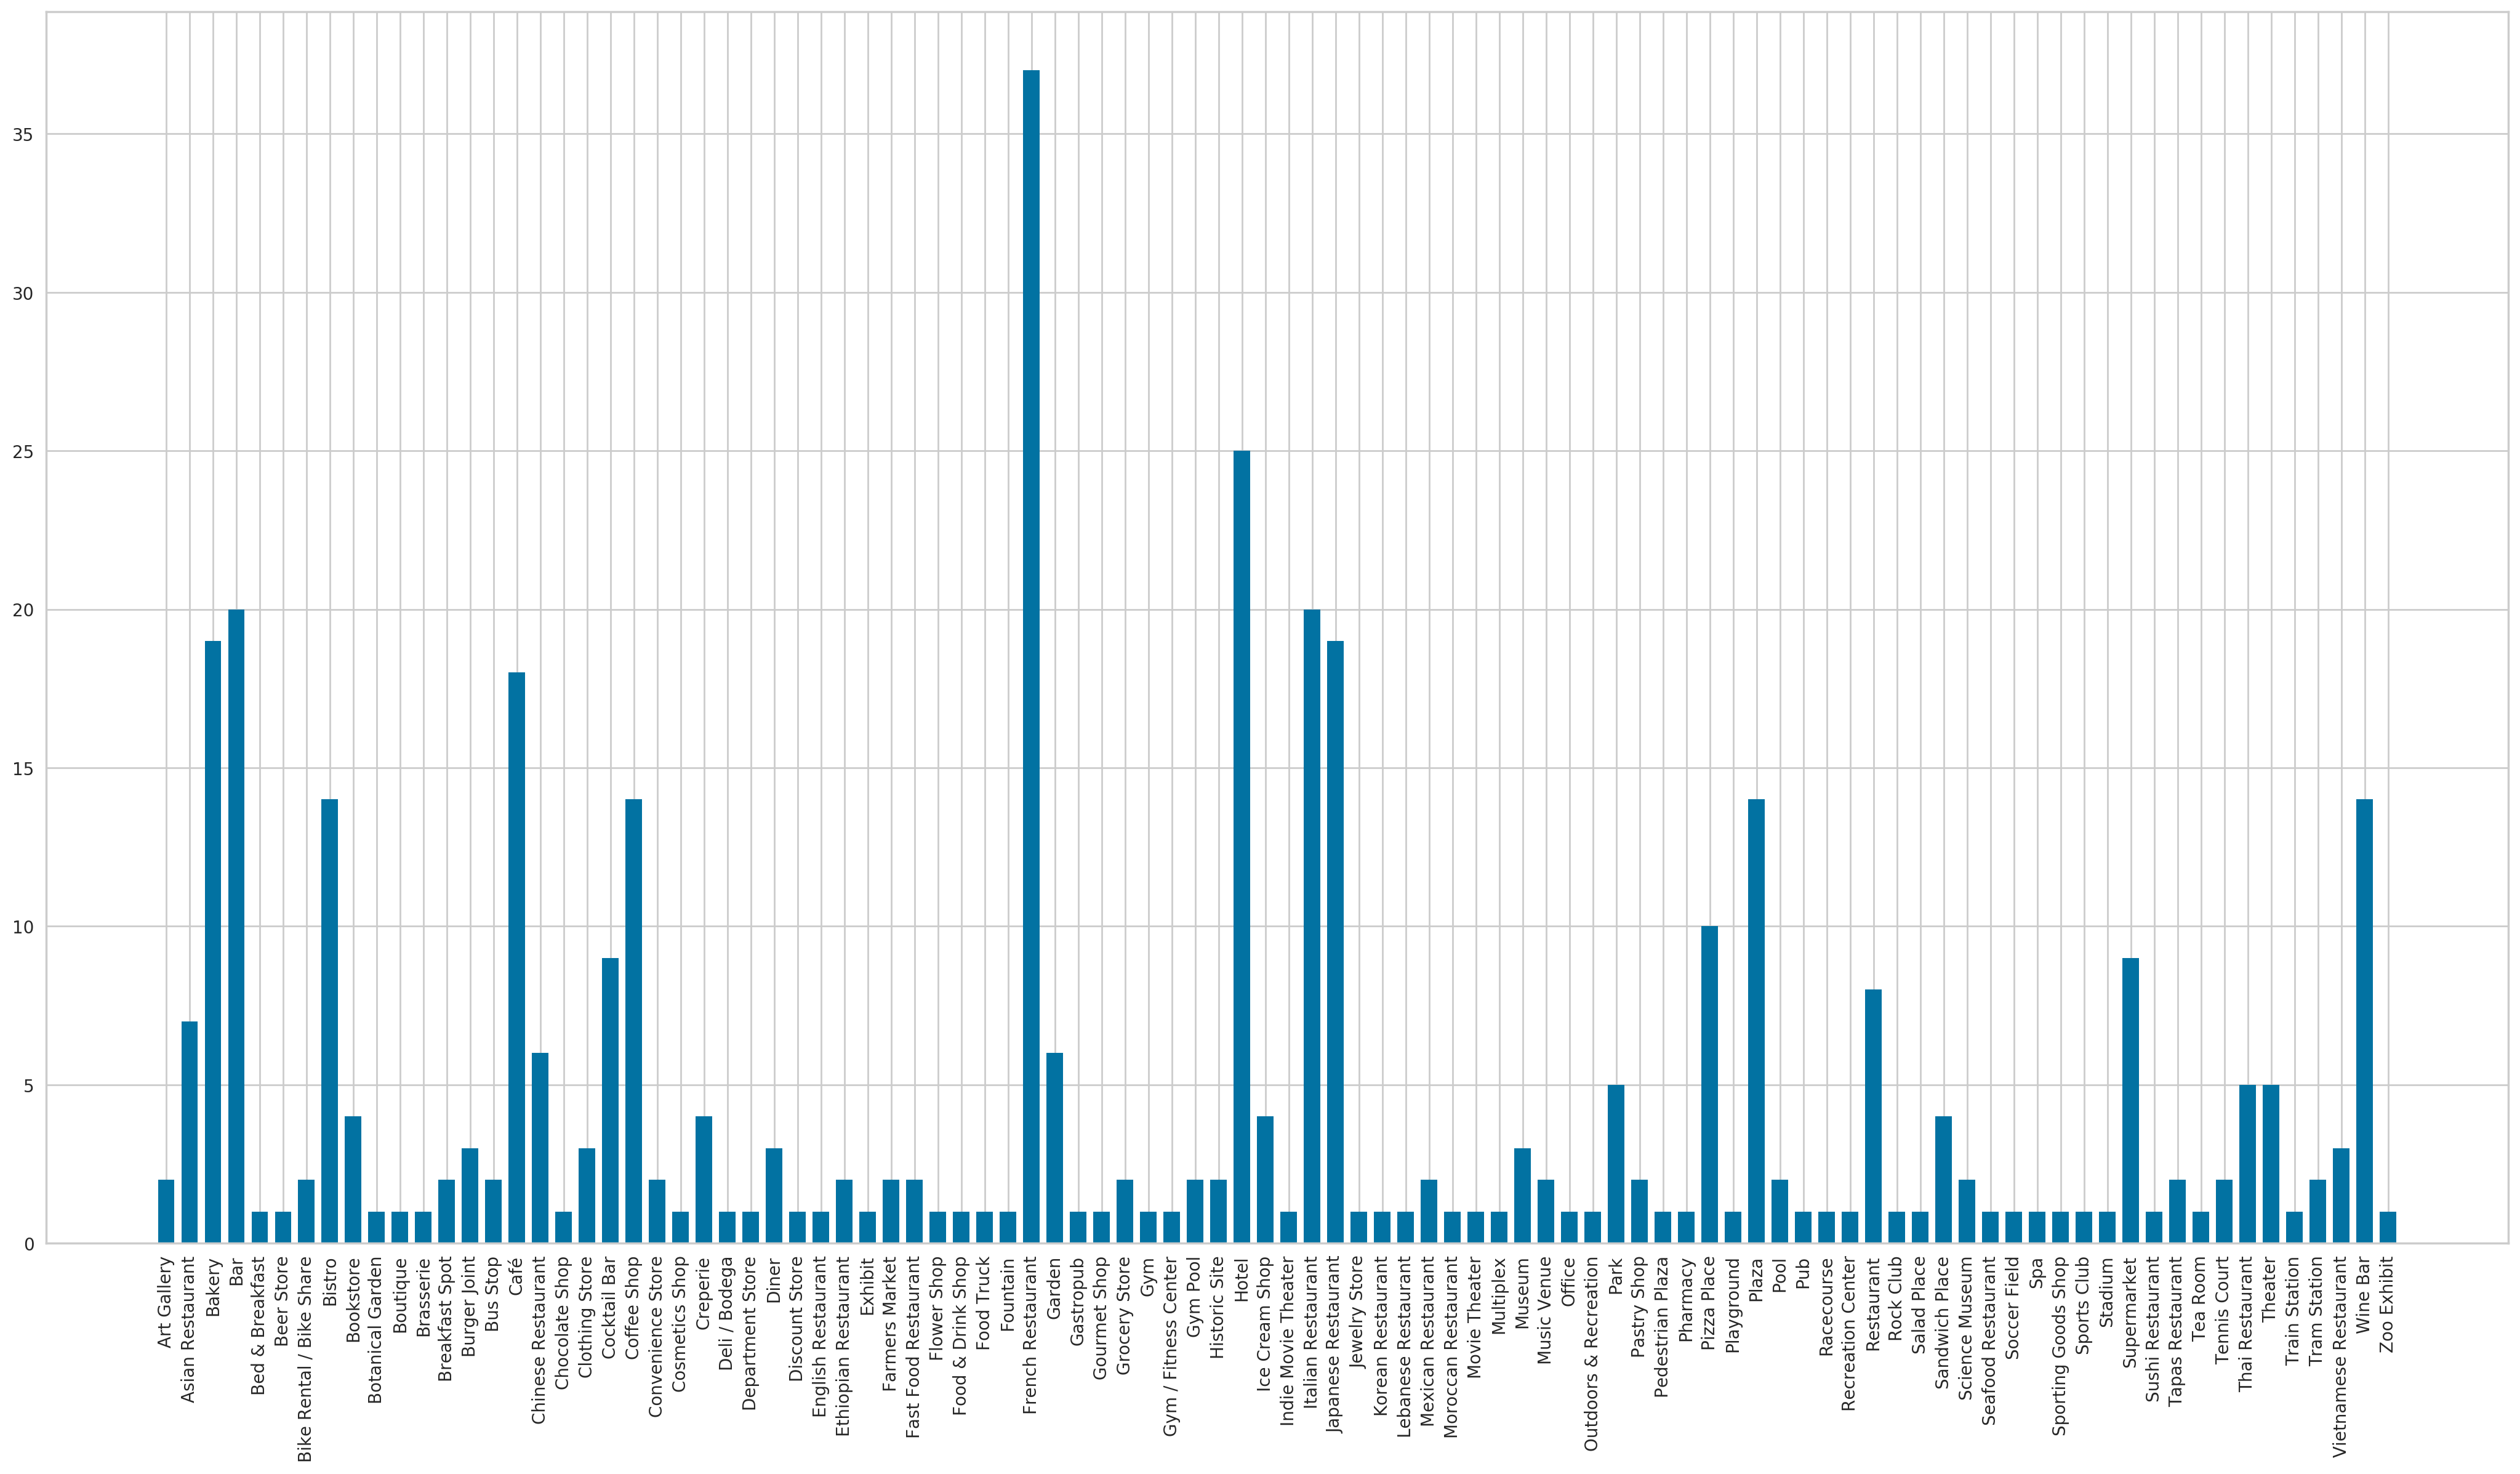

In [65]:
temp_series = pd.Series(dtype='object') 
temp_cluster = cluster_2.drop('Neighborhood', 1)
for c in temp_cluster.columns:
    temp = temp_cluster[c].value_counts()
    temp_series = temp_series.append(temp)
bar_cluster2 = temp_series.to_frame()
bar_cluster2.reset_index(inplace = True)
bar_cluster2.columns = ['Venue','Counts']
bar_cluster2 = bar_cluster2.groupby('Venue').sum()
fig = plt.figure(figsize=(20,10),dpi=200)
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
ax.bar(list(bar_cluster2.index),list(bar_cluster2['Counts']),width=0.7)
plt.savefig('Cluster2.jpeg',dpi=plt.gcf().dpi, bbox_inches = 'tight')
plt.show()

### Cluster-3

In [66]:
cluster_3 = paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]
cluster_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Halles,French Restaurant,Bakery,Hotel,Ice Cream Shop,Art Gallery,Cocktail Bar,Pedestrian Plaza,Cheese Shop,Coffee Shop,Plaza
1,Place-Vendôme,French Restaurant,Hotel,Jewelry Store,Chocolate Shop,Japanese Restaurant,Boutique,Dessert Shop,Bookstore,Hotel Bar,Italian Restaurant
2,Saint-Germain-l'Auxerrois,French Restaurant,Hotel,Plaza,Art Museum,Historic Site,Coffee Shop,Italian Restaurant,Cosmetics Shop,Exhibit,Clothing Store
12,Arsenal,French Restaurant,Hotel,Plaza,Seafood Restaurant,Park,Tapas Restaurant,Pedestrian Plaza,Cocktail Bar,Gastropub,Vegetarian / Vegan Restaurant
14,Saint-Merri,French Restaurant,Ice Cream Shop,Art Gallery,Café,Plaza,Historic Site,Italian Restaurant,Coffee Shop,Gourmet Shop,Pedestrian Plaza
17,Saint-Victor,French Restaurant,Hotel,Bakery,Italian Restaurant,Bar,Plaza,Japanese Restaurant,Bistro,Museum,Pub
20,Notre-Dame-des-Champs,French Restaurant,Hotel,Bakery,Japanese Restaurant,Italian Restaurant,Bistro,Steakhouse,Creperie,Cosmetics Shop,Chocolate Shop
23,Saint-Germain-des-Prés,French Restaurant,Italian Restaurant,Hotel,Plaza,Wine Bar,Café,Sandwich Place,Historic Site,Boutique,Pastry Shop
24,Saint-Thomas-d'Aquin,French Restaurant,Hotel,Italian Restaurant,Art Gallery,Café,Historic Site,Bakery,Cheese Shop,Tailor Shop,Bistro
25,Ecole-Militaire,Hotel,French Restaurant,Plaza,Asian Restaurant,Dessert Shop,Farmers Market,Bistro,Café,Historic Site,Diner


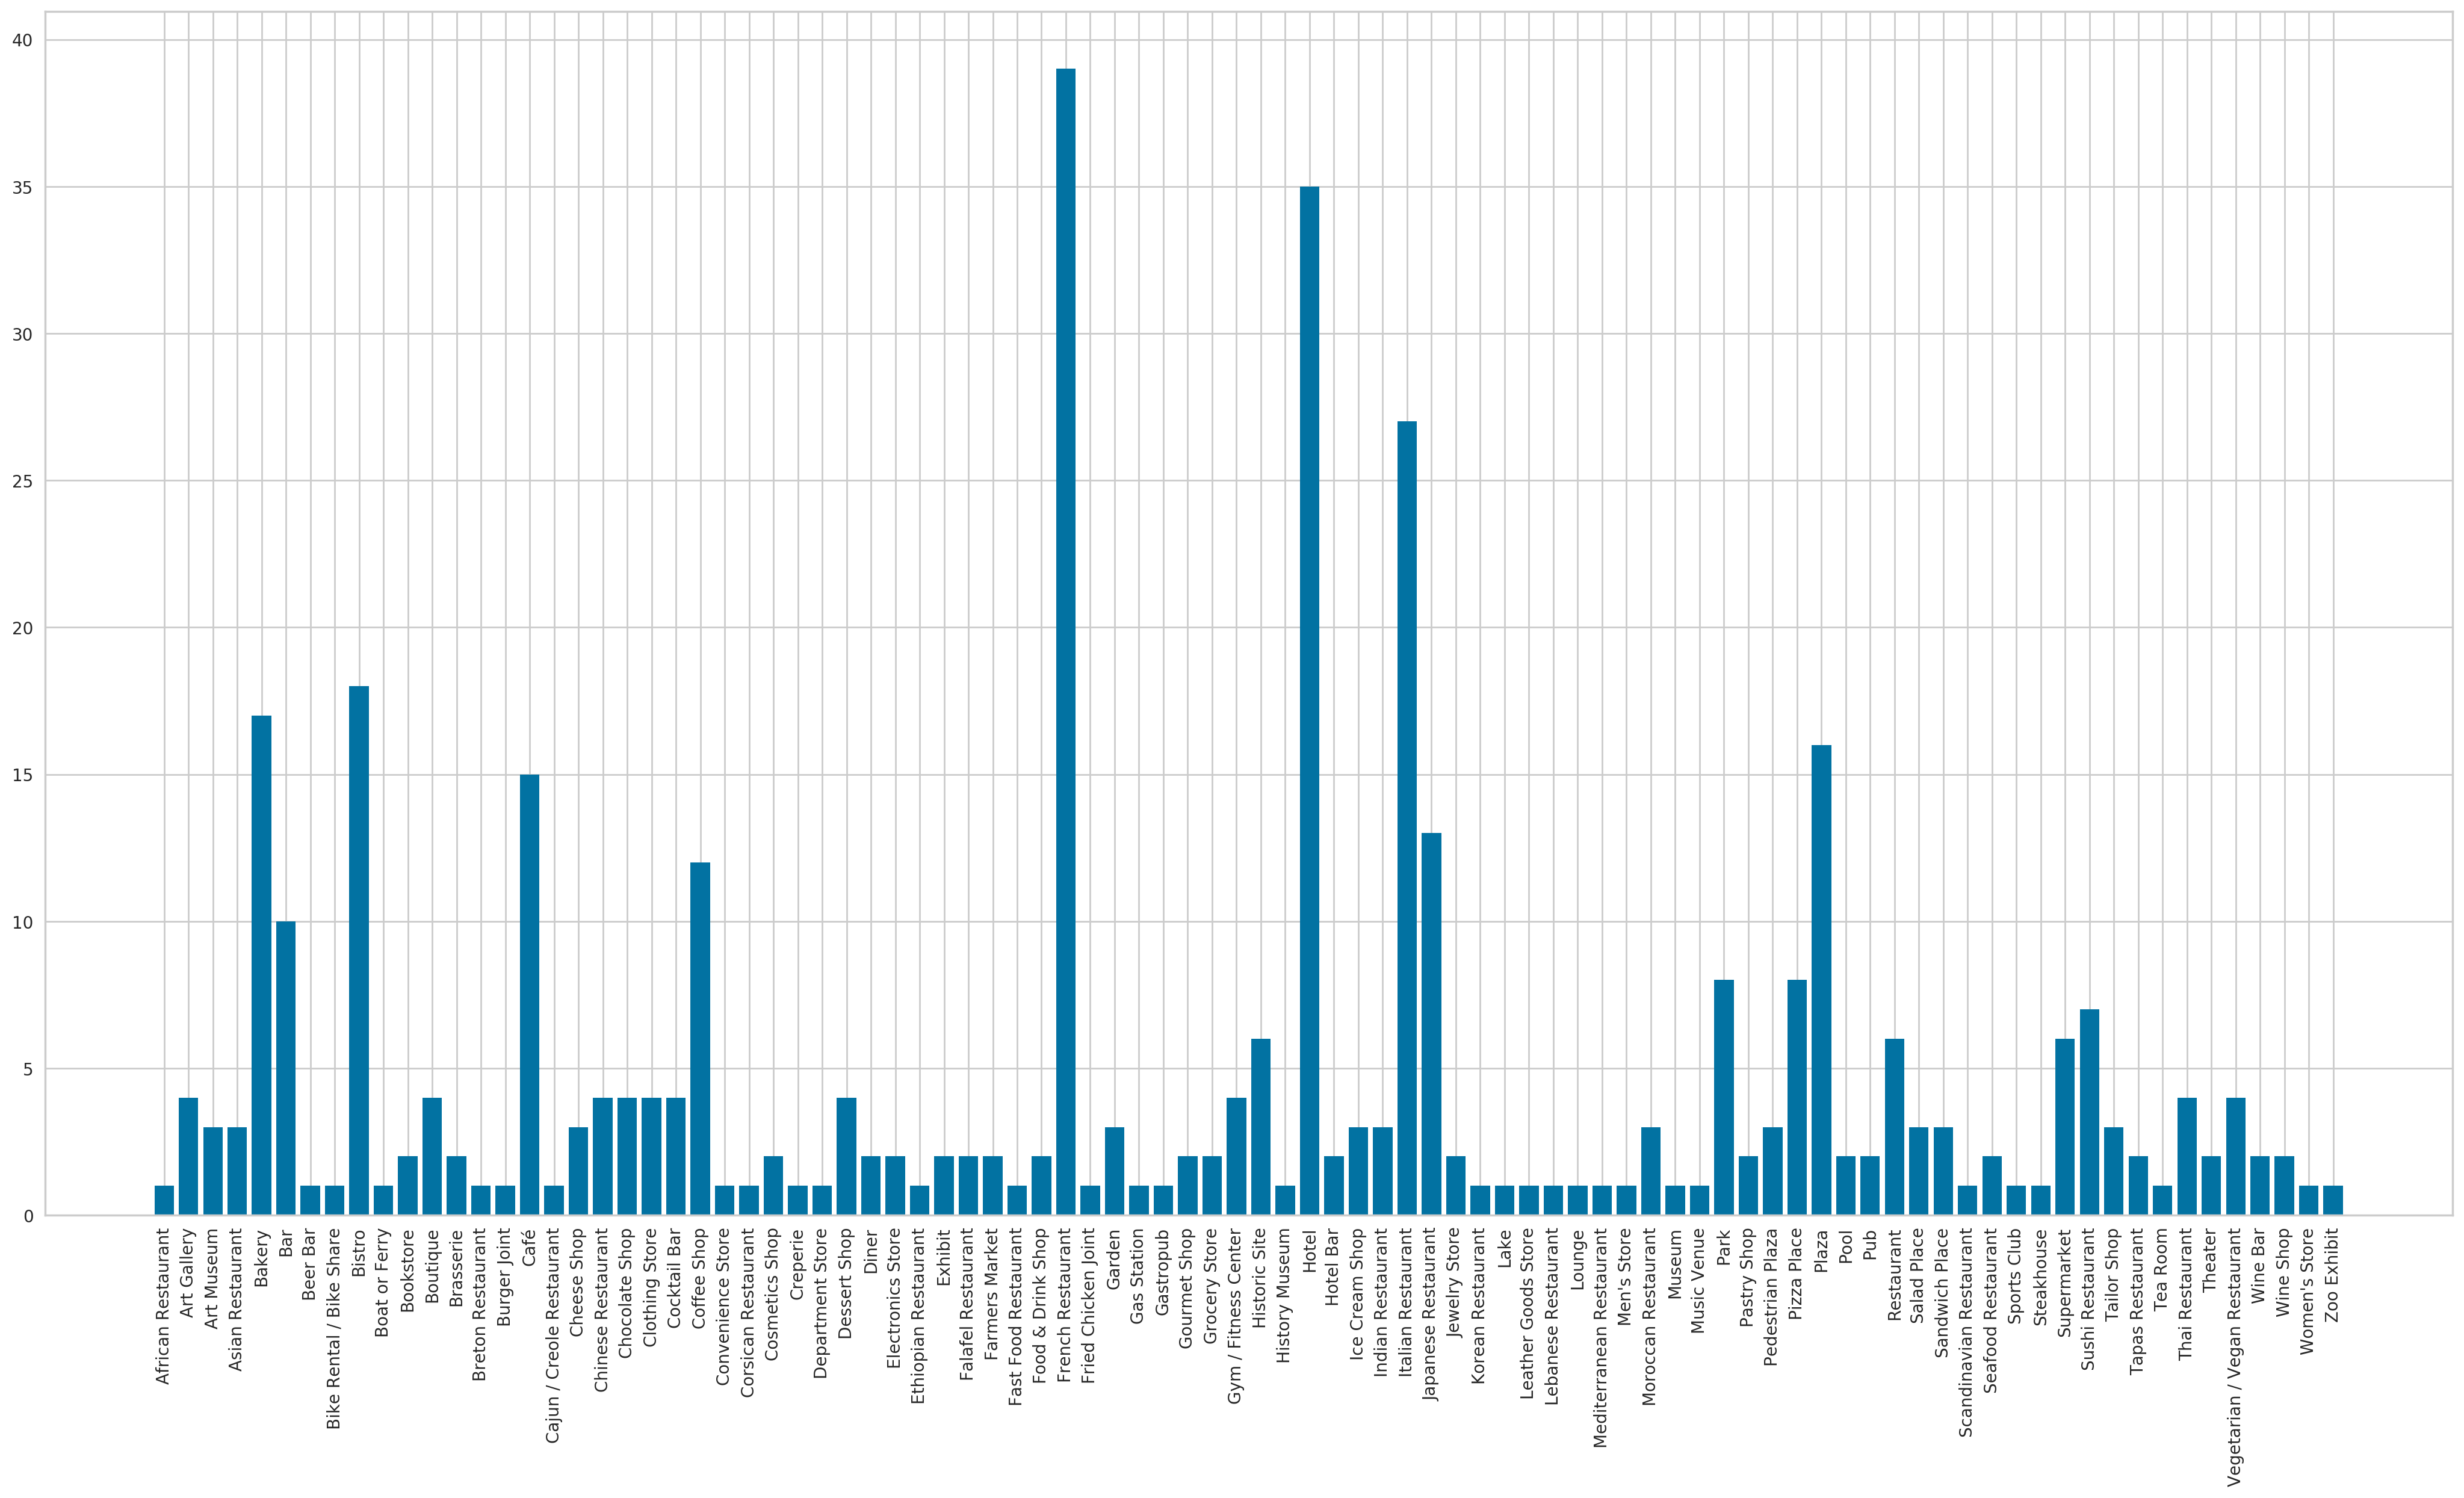

In [67]:
temp_series = pd.Series(dtype='object') 
temp_cluster = cluster_3.drop('Neighborhood', 1)
for c in temp_cluster.columns:
    temp = temp_cluster[c].value_counts()
    temp_series = temp_series.append(temp)
bar_cluster3 = temp_series.to_frame()
bar_cluster3.reset_index(inplace = True)
bar_cluster3.columns = ['Venue','Counts']
bar_cluster3 = bar_cluster3.groupby('Venue').sum()
fig = plt.figure(figsize=(20,10),dpi=200)
ax = fig.add_axes([0,0,1,1])
plt.xticks(rotation='vertical')
ax.bar(list(bar_cluster3.index),list(bar_cluster3['Counts']))
plt.savefig('Cluster3.jpeg',dpi=plt.gcf().dpi, bbox_inches = 'tight')
plt.show()

### Conclusion

To conclude, from the above clusters it can be derived that Cluster-1 does not provide any valuable information. Cluster-2 seems more popular for Restaurants, Cafes, Wine Bar, Bistros, and SuperMarkets. Cluster-3 also being popular for restaurants includes Vegetarian/Vegan restaurants in contrast to Cluster-2 (having none) and other common venues like Parks, Plaza, Clothing Stores, Gym and Fitness centers, and Historic Sites.